# Basque Country Weather Evolution

In this kernel I am going to explore the weather evolution during the last 100 years (if data exists) in the region of the Basque Country.

# Table of contents

<nav>
  <ol>
    <li><a href="#introduction">Introduction</a></li>
    <li><a href="#2-BC-data">Basque Country data accessing</a></li>
    <li><a href="#3-data-cleaning">Basque Country data clean and merge</a></li>
  </ol>
</nav>


# 1 - Introduction <a id="introduction"></a>

I will analyse the impact of climate change in the Basque Country region. The weather data has been obtained throuhg AEMET API.

### Hypothesis

- Regions experiencing greater increases in temperature also show greater levels of drought.
- Precipitation has decreased in recent decades, increasing drought conditions.
- Water management has had to adapt significantly in response to changing climate conditions.
- Global warming causes an increase in the average temperature of the territory but also in adverse phenomena such as extreme cold and precipitation.

# 2 - Importing libraries and data


In [1]:
import os
import re
import sys
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from matplotlib.patches import Rectangle

from utils import datascience as ds
from utils import functions as f            
from utils import vizdatatools as viz


In [2]:
# Import data from basque country (euskadi)
df_euskadi_original = pd.read_csv('./data/processed/BC_month_year_climate.csv')

In [3]:
# Delete displayed columns-limit
pd.set_option('display.max_columns', None)

df_euskadi_original.sample(7)

,fecha,idema,p_max,hr,nw_55,tm_min,ta_max,ts_min,nt_30,w_racha,np_100,nw_91,np_001,ta_min,w_rec,e,np_300,p_mes,w_med,nt_00,ti_max,tm_mes,tm_max,np_010,n_cub,n_des,n_nub,evap,n_fog,n_tor,n_gra,n_llu,n_nie,nv_0050,nv_1000,nv_0100,q_max,q_mar,q_med,q_min,inso,p_sol,ts_20,ts_10,ts_50,glo,latitud,provincia,altitud,nombre,indsinop,longitud
2427,2001-1,1024E,30.2(23),71.0,22.0,7.6,19.4(05),12.6,0.0,18/33.1(22),5.0,7.0,19.0,4.0(30),618.0,86.0,1.0,146.8,26.0,0.0,7.2,10.0,12.4,19.0,19.0,1.0,11.0,1047.0,2.0,2.0,0.0,21.0,0.0,0.0,1.0,0.0,995.4(20),1012.5,981.6,963.1(28),2.6,27.0,8.2,8.4,8.7,13786.0,43.306389,GIPUZKOA,250,"DONOSTIA / SAN SEBASTIÁN, IGELDO",8027.0,-2.041111
10133,2008-3,9091O,27.0(23),77.0,6.0,2.4,21.2(14),8.5,0.0,23/21.1(10),6.0,0.0,19.0,-1.0(10),297.0,84.0,0.0,161.5,14.0,8.0,5.0,7.5,12.5,17.0,17.0,0.0,14.0,888.0,5.0,3.0,2.0,17.0,2.0,0.0,3.0,0.0,970.6(05),1017.2,956.7,939.3(22),4.2,35.0,9.7,10.4,10.0,NaN,42.881944,ARABA/ALAVA,513,FORONDA-TXOKIZA,8080.0,-2.735000
2728,2018-2,1025A,23.8(01),87.0,1.0,1.1,19.5(16),8.5,0.0,10/16.1(28),10.0,0.0,21.0,-6.7(27),61.0,79.0,0.0,205.0,2.0,10.0,3.3,4.8,8.6,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.015556,GIPUZKOA,255,SEGURA,NaN,-2.256667
8706,2023-6,1082,33.5(18),73.0,0.0,16.6,31.0(24),20.0,2.0,99/13.3(09),3.0,0.0,16.0,13.3(16),211.0,192.0,1.0,75.6,11.0,0.0,20.7,21.2,25.8,9.0,16.0,1.0,13.0,NaN,2.0,7.0,0.0,16.0,0.0,0.0,0.0,0.0,1021.4(22),1015.9,1011.3,1000.5(08),5.6,36.0,NaN,NaN,NaN,55103.0,43.298056,BIZKAIA,42,BILBAO AEROPUERTO,8025.0,-2.906389
9934,1991-8,9091O,2.0(08),65.0,0.0,13.5,36.6(28),16.6,13.0,23/15.0(22),0.0,0.0,5.0,9.5(02),215.0,172.0,0.0,6.3,10.0,0.0,18.0,21.4,29.2,4.0,2.0,9.0,20.0,2014.0,3.0,3.0,0.0,7.0,0.0,0.0,1.0,0.0,967.4(10),1017.0,959.5,951.5(21),9.3,67.0,NaN,NaN,NaN,NaN,42.881944,ARABA/ALAVA,513,FORONDA-TXOKIZA,8080.0,-2.735000
7579,2007-5,1078I,36.3(20),75.0,6.0,10.0,28.8(09),14.8,0.0,20/20.3(12),4.0,0.0,19.0,3.1(02),154.0,128.0,1.0,109.4,7.0,0.0,13.8,14.9,19.7,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003.9(07),1015.0,990.5,978.1(13),NaN,NaN,NaN,NaN,NaN,NaN,43.203333,BIZKAIA,208,GÜEÑES,8035.0,-3.104722
9291,1948-1,9087,26.7(20),81.0,NaN,2.8,17.6(04),11.2,0.0,NaN,5.0,NaN,19.0,-4.0(01),NaN,84.0,0.0,133.0,NaN,7.0,2.4,6.7,10.5,14.0,20.0,0.0,11.0,900.0,0.0,1.0,0.0,21.0,3.0,0.0,0.0,0.0,NaN,1016.9,955.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.849722,ARABA/ALAVA,521,VITORIA AERÓDROMO,NaN,-2.656111


These are the variables I will be working with:

- fecha: year and month, string (YYYY-MM)
- idema: AWS (Automatic Weather Stations) id, string
- nombre: name (location) of the station, string
- provincia: province of the station, string
- altitud: station altitude in meters above sea level, m

- tm_mes: Monthly average temperature, °C
- tm_max: Monthly average of maximum temperatures, °C
- tm_min: Monthly average of minimum temperatures, °C
- ta_max: Absolute maximum temperature of the month and date, °C (day)
- ta_min: Absolute minimum temperature of the month and date, °C (day)
- ts_min: Highest minimum temperature of the month, °C
- ti_max: Lowest maximum temperature of the month, °C
- nt_30: Number of days with maximum temperature greater than or equal to 30 °C, number of days
- nt_00: Number of days with minimum temperature less than or equal to 0 °C, number of days

- p_mes: Total monthly precipitation, mm
- p_max: Maximum daily precipitation of the month and date, mm (day)
- np_001: Number of days with appreciable precipitation (>= 0.1 mm) in the month, number of days
- np_010: Number of days with precipitation greater than or equal to 1 mm in the month, number of days
- np_100: Number of days with precipitation greater than or equal to 10 mm in the month, number of days
- np_300: Number of days with precipitation greater than or equal to 30 mm in the month, number of days

- hr: Monthly average relative humidity, %
- e: Monthly average vapor pressure, tenths of hPa
- n_llu: Number of rainy days in the month, number of days
- n_nie: Number of snowy days in the month, number of days
- n_gra: Number of hail days in the month, number of days
- n_tor: Number of stormy days in the month, number of days
- n_fog: Number of foggy days in the month, number of days
- n_des: Number of clear days in the month, number of days
- n_nub: Number of cloudy days in the month, number of days
- n_cub: Number of overcast days in the month, number of days
- inso: Monthly average daily sunshine, hours
- p_sol: Monthly average percentage of daily sunshine relative to theoretical sunshine, %
- glo: Monthly global radiation, tens of kJ/m2
- evap: Total monthly evaporation, tenths of mm

- w_rec: Monthly average daily wind travel (from 07 to 07 UTC), km
- w_racha: Direction, speed, and date of the maximum gust in the month, direction in tens of degrees (99 = variable direction)(88 = no direction data), speed in m/s
- nw_55: Number of days with wind speed greater than or equal to 55 km/h in the month, number of days
- nw_91: Number of days with wind speed greater than or equal to 91 km/h in the month, number of days
- w_med: Monthly average wind speed based on observations at 07, 13, and 18 UTC, km/h

- q_med: Monthly average pressure at station level, hPa
- q_max: Absolute maximum monthly pressure and date, hPa
- q_min: Absolute minimum monthly pressure and date, hPa
- q_mar: Monthly average pressure at sea level, hPa

- ts_10: Monthly average temperature at 10 cm depth, °C
- ts_20: Monthly average temperature at 20 cm depth, °C
- ts_50: Monthly average temperature at 50 cm depth, °C

- nv_0050: Number of days with visibility less than 50 m in the month, number of days
- nv_0100: Number of days with visibility greater than or equal to 50 m and less than 100 m in the month, number of days
- nv_1000: Number of days with visibility greater than or equal to 100 m and less than 1 km in the month, number of days

In [4]:
# Exploring data, missing values and type
df_euskadi_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11448 entries, 0 to 11447
Data columns (total 52 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      11448 non-null  object 
 1   idema      11448 non-null  object 
 2   p_max      10419 non-null  object 
 3   hr         9111 non-null   float64
 4   nw_55      7747 non-null   float64
 5   tm_min     10148 non-null  float64
 6   ta_max     10143 non-null  object 
 7   ts_min     10115 non-null  float64
 8   nt_30      10143 non-null  float64
 9   w_racha    7772 non-null   object 
 10  np_100     10410 non-null  float64
 11  nw_91      7747 non-null   float64
 12  np_001     10410 non-null  float64
 13  ta_min     10148 non-null  object 
 14  w_rec      7463 non-null   float64
 15  e          9176 non-null   float64
 16  np_300     10410 non-null  float64
 17  p_mes      10423 non-null  float64
 18  w_med      8550 non-null   float64
 19  nt_00      10148 non-null  float64
 20  ti_max

In [5]:
print(df_euskadi_original.shape)
print(df_euskadi_original.nunique())

(11448, 52)
fecha        1164
idema          37
p_max        7370
hr             48
nw_55          29
tm_min        233
ta_max       5419
ts_min        225
nt_30          22
w_racha      6907
np_100         20
nw_91          15
np_001         31
ta_min       4844
w_rec         585
e             185
np_300         10
p_mes        2739
w_med          33
nt_00          28
ti_max        281
tm_mes        234
tm_max        271
np_010         29
n_cub          29
n_des          17
n_nub          27
evap         1274
n_fog          22
n_tor          13
n_gra          10
n_llu          29
n_nie          15
nv_0050        12
nv_1000        14
nv_0100         4
q_max        3970
q_mar         258
q_med         706
q_min        4172
inso           94
p_sol          63
ts_20         200
ts_10         201
ts_50         183
glo          1241
latitud        36
provincia       3
altitud        34
nombre         37
indsinop       10
longitud       36
dtype: int64


In [6]:
df_euskadi_original.describe()

,hr,nw_55,tm_min,ts_min,nt_30,np_100,nw_91,np_001,w_rec,e,np_300,p_mes,w_med,nt_00,ti_max,tm_mes,tm_max,np_010,n_cub,n_des,n_nub,evap,n_fog,n_tor,n_gra,n_llu,n_nie,nv_0050,nv_1000,nv_0100,q_mar,q_med,inso,p_sol,ts_20,ts_10,ts_50,glo,latitud,altitud,indsinop,longitud
count,9111.000000,7747.000000,10148.000000,10115.000000,10143.000000,10410.000000,7747.00000,10410.000000,7463.000000,9176.000000,10410.000000,10423.000000,8550.000000,10148.000000,10110.000000,10137.000000,10143.000000,10410.000000,4968.000000,4968.000000,4968.000000,3576.000000,4309.000000,4305.000000,4307.000000,4307.000000,4307.000000,3829.000000,3829.000000,3829.000000,4799.000000,4876.000000,3836.000000,3836.000000,686.000000,691.000000,688.000000,1254.000000,11448.000000,11448.000000,5856.000000,11448.000000
mean,75.989793,4.827675,9.021817,14.834048,1.356009,3.384438,0.49361,14.534774,222.453571,124.641129,0.578386,103.898072,9.998363,1.635692,11.019693,13.531193,17.997456,10.629683,13.283011,2.984903,14.127013,848.837248,3.707125,1.737282,0.450662,14.733689,0.485953,0.425437,1.487072,0.033429,1018.320859,993.256809,4.831830,38.642857,13.865015,14.519247,13.790552,37462.404306,43.139450,275.236897,8037.846311,-2.484228
std,6.773504,4.936427,4.551799,4.089205,2.784430,3.031640,1.32750,5.086512,116.258365,38.472750,1.044340,82.224069,4.798209,3.611684,5.713597,4.910950,5.549755,4.756027,4.461275,2.641139,3.980748,368.982414,3.553295,1.874790,0.976056,4.797273,1.421576,1.153791,1.935116,0.204266,4.108479,23.088747,1.848054,11.048816,5.741484,5.962663,5.276148,17627.919790,0.225887,228.964594,19.526949,0.407820
min,50.000000,0.000000,-6.200000,1.400000,0.000000,0.000000,0.00000,0.000000,11.000000,49.000000,0.000000,0.000000,0.000000,0.000000,-8.200000,-2.800000,0.700000,0.000000,1.000000,0.000000,2.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1001.300000,946.600000,0.700000,7.000000,2.200000,4.000000,4.300000,8869.000000,42.567222,4.000000,8024.000000,-3.231667
25%,72.000000,1.000000,5.500000,11.800000,0.000000,1.000000,0.00000,11.000000,133.000000,92.000000,0.000000,45.500000,6.000000,0.000000,6.600000,9.600000,13.600000,7.000000,10.000000,1.000000,11.000000,585.750000,1.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,1016.100000,968.800000,3.300000,30.000000,8.700000,9.200000,8.800000,18984.500000,43.025000,90.000000,8026.000000,-2.752778
50%,76.000000,3.000000,8.800000,15.000000,0.000000,3.000000,0.00000,14.000000,200.000000,116.000000,0.000000,81.800000,9.000000,0.000000,10.900000,13.400000,17.900000,10.000000,13.000000,2.000000,14.000000,803.000000,3.000000,1.000000,0.000000,15.000000,0.000000,0.000000,1.000000,0.000000,1018.100000,994.500000,4.800000,39.000000,13.350000,14.200000,13.250000,39418.500000,43.203333,250.000000,8029.000000,-2.510278
75%,81.000000,7.000000,12.800000,18.100000,1.000000,5.000000,0.00000,18.000000,281.000000,156.000000,1.000000,138.900000,13.000000,1.000000,15.800000,17.900000,22.700000,14.000000,16.000000,4.000000,17.000000,1042.000000,6.000000,3.000000,1.000000,18.000000,0.000000,0.000000,2.000000,0.000000,1020.400000,1014.400000,6.200000,47.000000,19.375000,20.000000,19.000000,53246.500000,43.306389,513.000000,8036.000000,-2.184167
max,97.000000,28.000000,20.500000,26.600000,21.000000,19.000000,14.00000,30.000000,769.000000,270.000000,9.000000,626.900000,32.000000,29.000000,25.100000,24.900000,31.400000,28.000000,29.000000,16.000000,28.000000,3087.000000,21.000000,12.000000,11.000000,28.000000,17.000000,11.000000,13.000000,3.000000,1035.400000,1031.900000,10.600000,72.000000,25.400000,26.900000,23.800000,77732.000000,43.453889,910.000000,8080.000000,-1.792222


Many values are missing in this dataset but it is expected due to the following factors:
- Each AWS (Automatic Weather Stations) has been built in different year.
- Each AWS must not have all metereological sensors available, or may be broken at some period

# 3 - Modifying the dataset and choosing de data

- Cambiar a dataset
- Mostras categoricas (estaciones), frente a variables numéricas para ver qué pueblos tienen más información y quedarme solo con esas
- De las numéricas ver las tendencias por pueblo

In [7]:
# Do not modify the original DataFrame
df_euskadi = df_euskadi_original.copy()

# "fecha" to datetime
df_euskadi['fecha'] = pd.to_datetime(df_euskadi['fecha'])

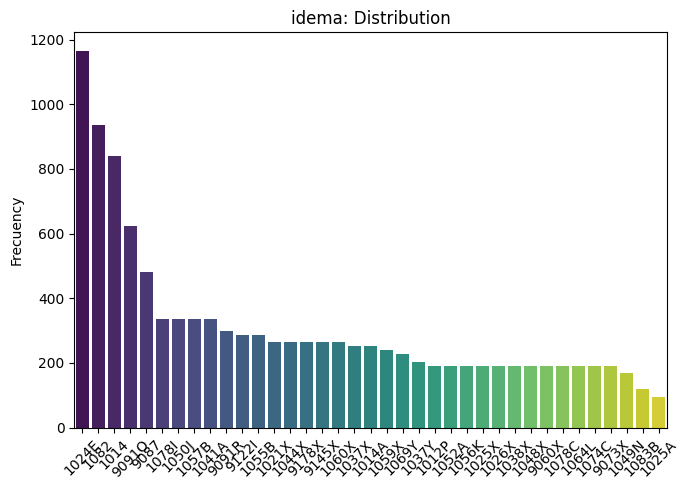

In [20]:
viz.plot_multiple_categorical_distributions(df_euskadi, ['idema'], show_values=False)



In [23]:
fig = plt.gcf()
# fig.set_size_inches(1,1)
# plt.show()

<Figure size 640x480 with 0 Axes>